In [19]:
import glob
import json
import io
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.options.display.max_rows = pd.options.display.max_columns = 100

%matplotlib inline

## 前処理ネタ

1. `name` に含まれる情報はクレンジングしておきたい
1. `name` の埋め込みベクトル、文字列長さ、単語数
  - `name` の言語はほぼ日本語、英語、中国語。まれにハングルがあるが両の手にすら満たない数かも。
    - 日本語 BERT: [cl-tohoku/bert-base-japanese-v2](https://huggingface.co/cl-tohoku/bert-base-japanese-v2).
    - 中国語 BERT: [bert-base-chinese](https://huggingface.co/bert-base-chinese), [hfl/chinese-bert-wwm-ext](https://huggingface.co/hfl/chinese-bert-wwm-ext).
  - FastText の言語識別モデルの結果は信用できそう。日本語英語中国語以外は英語で処理する。ハングルは90%超えたら信用できそうだ数は少ない。
  - [このノート](notebooks/nameって何語なの？.ipynb)
1. 今のレビュー数を得るのに何か月かかったのか
1. `host_id` のエンコーディング
    1. Frequency encoding
    1. レビュー履歴を集計する
    1. Cross table 集計で持っている物件の特徴を定量化（`neighbourhood`, `room_type` あたりがよさそう）
1. 最寄り駅 Top $N$ の名前と距離
    1. 駅名の重複に注意
    1. "押上（スカイツリー前）"、押上〈スカイツリー前〉の2つが存在するので注意（経度緯度は同じなので削除）
1. 経度緯度
    1. クラスタリングしてセントロイドからの距離を測る（場所が個性的度）
      - 多分クラスタ数は 9, 10 がちょうど良さそう
    1. 自身から $N$ の距離内の駅数（利便性の尺度？）
    1. 自身から $N$ の距離内の民泊数（競争過密度？）

1. 同じ価格の民泊がたくさんありそう？調べてみる。


## やってみたいこと

|No|CV|
|---:|:---|
|1|特徴量：`neighbourhood`, `latitude`, `longitude`, `room_type`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `availability_365`, `review_date`, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|v
|2|特徴量：2 + `name` を train と test で共有されていなければ専用の値でマスク, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|
|3|特徴量：2 + `name` を Tf-IDF+LSIで64次元のベクトルに 
|4|特徴量：2 + `name` を Tf-IDF+LDAで64次元のベクトルに 
|5|特徴量：2 + `name` を Tf-IDF+NMFで64次元のベクトルに
|6|特徴量：2 + `name` を Tf-IDF+LSIで32次元のベクトルに 
|7|特徴量：2 + `name` を Tf-IDF+LDAで32次元のベクトルに 
|8|特徴量：2 + `name` を Tf-IDF+NMFで32次元のベクトルに
|9|特徴量：2 + `name` を Tf-IDF+LSIで16次元のベクトルに 
|10|特徴量：2 + `name` を Tf-IDF+LDAで16次元のベクトルに 
|11|特徴量：2 + `name` を Tf-IDF+NMFで16次元のベクトルに
|12|No.3 の Fold を StratifiedKFold(`y`を binning したやつ) + `name` はクレンジング|
|13|No.3 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|14|No.5 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|15|No.5 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|16|No.6 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|17|No.6 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|18|No.8 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|19|No.8 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|20|No.5 に `name` のクレンジングを忘れていたので追加|
|21|No.20 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|22|No.14 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|23|No.15 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|24|No.20 にクラスタリングの特徴量を追加, クラスタ数は9|
|25|No.14 にクラスタリングの特徴量を追加, クラスタ数は9|
|26|No.15 にクラスタリングの特徴量を追加, クラスタ数は9|
|27|No.20 にクラスタリングの特徴量を追加, クラスタ数は10|
|28|No.14 にクラスタリングの特徴量を追加, クラスタ数は10|
|29|No.15 にクラスタリングの特徴量を追加, クラスタ数は10|
|30|No.20 に最寄り駅の特徴量を追加|
|31|No.14 に最寄り駅の特徴量を追加|
|32|No.15 に最寄り駅の特徴量を追加|
|33|No.20 に近くの民泊数の特徴量を追加|
|34|No.14 に近くの民泊数の特徴量を追加|
|35|No.15 に近くの民泊数の特徴量を追加|
|36|No.20 + `name` を Bert pretrained model で埋め込みにしたもの|
|37|No.14 + `name` を Bert pretrained model で埋め込みにしたもの|
|38|No.15 + `name` を Bert pretrained model で埋め込みにしたもの|
|39|No.20 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|40|No.14 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|41|No.15 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|42|No.20 + `name` を言語に応じた Tokenization を掛けてから TF-IDF して NMF で64次元にするもの|
|43|No.14 + `name` を言語に応じた Tokenization を掛けてから TF-IDF して NMF で64次元にするもの|
|44|No.15 + `name` を言語に応じた Tokenization を掛けてから TF-IDF して NMF で64次元にするもの|
|45|No.20 + `host_id` をエンコード|
|46|No.14 + `host_id` をエンコード|
|47|No.15 + `host_id` をエンコード|
|48|No.20 + LSI64次元, `name` は Languagewise vectorization|
|49|No.14 + LSI64次元, `name` は Languagewise vectorization|
|50|No.15 + LSI64次元, `name` は Languagewise vectorization|
|51|No.20 の `name` ベクトルをLSI64次元のみに, `name` は Languagewise vectorization|
|52|No.14 の `name` ベクトルをLSI64次元のみに, `name` は Languagewise vectorization|
|53|No.15 の `name` ベクトルをLSI64次元のみに, `name` は Languagewise vectorization|
|54|No.48 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|55|No.49 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|56|No.50 + `name` を言語に応じた Bert pretrained model で埋め込みにしたもの|
|57|No.54 のモデルをLightGBM に|
|58|No.55 のモデルをLightGBM に|
|59|No.56 のモデルをLightGBM に|
|60|No.51 + 最寄駅の情報|
|61|No.52 + 最寄駅の情報|
|62|No.53 + 最寄駅の情報|
|63|No.51 + 近くの民泊数|
|64|No.52 + 近くの民泊数|
|65|No.53 + 近くの民泊数|
|66|No.51 + クラスタリングの特徴量|
|67|No.52 + クラスタリングの特徴量|
|68|No.53 + クラスタリングの特徴量|

- 2022-04-28  
  - No.11 まで実施するも CV vs LB の並びが気に食わない。相関は強そうだがロスに差があるのはさておき順位が一致しないのが気持ち悪い。StratifiedKFold(`neighbourhood`)以外の方法も試して信頼できる CV を探したい。No.3, 5, 6, 8 を対象に以下を試す。
    - StratifiedKFold: `y`を binning して bin を層とみなす
    - GroupKFold(`host_id`): [このDiscussion](https://comp.probspace.com/competitions/bnb_price/discussions/shirapon24-Postde0ee1e20bc5d402eea0) でやってる人がいる。

- 2022-04-30  
  - No.12-19 を行い5サブ使って CV と LB の相関を確認する。相関はしているが CV と LB とで順位が合わないことがあり気持ち悪い。
  - No.44 までつらつらと書き連ねた。
  - 今のレビュー数を得るのに何か月かかったのかの特徴量は無い方が良い？
  - 同じ `name` で場所も同じっぽいのに `host_id` が違うと価格が大きく変わることがある。`host_id` から予測に役立つ情報をどう抽出するのか？を考えられたらスコア大きく伸びるかも？
  - No.19 以降は表の番号と実際のノートがあっていないかもしれないから要チェック。
  
- 2022-05-01
  - 024 の途中で `name` のクレンジングを間違えて test の一部が欠損していることに気づいたから修正した
  
- 2022-05-02
  - CV と LB がまるで一致しない。

## CV vs LB

In [20]:
submissions = """ファイル名	提出者	ステータス	提出時間	Publicスコア	Privateスコア	メッセージ	操作	最終提出
submission_074.csv	Quvotha-nndropout100	成功	7分 前	0.83080	0.79209	csv提出済み		
submission_063.csv	Quvotha-nndropout100	成功	約1時間 前	0.80758	0.74792	csv提出済み		
submission_069.csv	Quvotha-nndropout100	成功	約2時間 前	0.81062	0.75718	csv提出済み		
submission_066.csv	Quvotha-nndropout100	成功	約2時間 前	0.80580	0.74878	csv提出済み		
submission_048.csv	Quvotha-nndropout100	成功	約2時間 前	0.80913	0.74826	csv提出済み		
submission_045.csv	Quvotha-nndropout100	成功	5日 前	0.82435	0.78487	csv提出済み		
submission_039.csv	Quvotha-nndropout100	成功	5日 前	0.81531	0.76113	csv提出済み		
submission_042.csv	Quvotha-nndropout100	成功	5日 前	0.80917	0.75172	csv提出済み		
submission_033.csv	Quvotha-nndropout100	成功	5日 前	0.80234	0.74914	csv提出済み		
submission_036.csv	Quvotha-nndropout100	成功	5日 前	0.82111	0.76438	csv提出済み		
submission_032.csv	Quvotha-nndropout100	成功	6日 前	0.81128	0.76706	csv提出済み		
submission_027.csv	Quvotha-nndropout100	成功	6日 前	0.80365	0.75035	csv提出済み		
submission_026.csv	Quvotha-nndropout100	成功	6日 前	0.80728	0.75444	csv提出済み		
submission_029.csv	Quvotha-nndropout100	成功	6日 前	0.80773	0.75448	csv提出済み		
submission_023.csv	Quvotha-nndropout100	成功	6日 前	0.80532	0.74988	csv提出済み		
submission_021.csv	Quvotha-nndropout100	成功	8日 前	0.80968	0.75019	csv提出済み		
submission_020.csv	Quvotha-nndropout100	成功	8日 前	0.80767	0.75205	csv提出済み		
submission_019.csv	Quvotha-nndropout100	成功	8日 前	0.82118	0.77372	csv提出済み		
submission_018.csv	Quvotha-nndropout100	成功	8日 前	0.81970	0.76957	csv提出済み		
submission_017.csv	Quvotha-nndropout100	成功	8日 前	0.83054	0.78203	csv提出済み		
submission_016.csv	Quvotha-nndropout100	成功	9日 前	0.82307	0.78059	csv提出済み		
submission_015.csv	Quvotha-nndropout100	成功	9日 前	0.80948	0.75500	csv提出済み		
submission_014.csv	Quvotha-nndropout100	成功	9日 前	0.80827	0.75127	csv提出済み		
submission_013.csv	Quvotha-nndropout100	成功	9日 前	0.82579	0.77307	csv提出済み		
submission_012.csv	Quvotha-nndropout100	成功	9日 前	0.82092	0.76860	csv提出済み		
submission_011.csv	Quvotha-nndropout100	成功	10日 前	0.83046	0.78116	csv提出済み		
submission_005.csv	Quvotha-nndropout100	成功	10日 前	0.80957	0.74914	csv提出済み		
submission_004.csv	Quvotha-nndropout100	成功	10日 前	0.85716	0.81363	csv提出済み		
submission_003.csv	Quvotha-nndropout100	成功	10日 前	0.82206	0.76806	csv提出済み		
submission_001.csv	Quvotha-nndropout100	成功	10日 前	0.86378	0.82680	csv提出済み		
submission_010.csv	Quvotha-nndropout100	成功	11日 前	0.86311	0.80967	csv提出済み		
submission_009.csv	Quvotha-nndropout100	成功	11日 前	0.83919	0.78482	csv提出済み		
submission_008.csv	Quvotha-nndropout100	成功	11日 前	0.82104	0.77139	csv提出済み		
submission_007.csv	Quvotha-nndropout100	成功	11日 前	0.84814	0.80661	csv提出済み		
submission_006.csv	Quvotha-nndropout100	成功	11日 前	0.82747	0.77984	csv提出済み		
submission_005.csv	Quvotha-nndropout100	成功	12日 前	1.17352	1.02125	csv提出済み		
submission_003.csv	Quvotha-nndropout100	成功	12日 前	1.05577	1.03976	csv提出済み		
submission_003.csv	Quvotha-nndropout100	成功	12日 前	1.08290	1.10933	csv提出済み		
submission_002.csv	Quvotha-nndropout100	成功	12日 前	1.08290	1.10933	csv提出済み		
submission_001.csv	Quvotha-nndropout100	成功	12日 前	1.10169	1.04713	csv提出済み"""
submissions = pd.read_csv(io.StringIO(submissions), sep='\t')
submissions

,ファイル名,提出者,ステータス,提出時間,Publicスコア,Privateスコア,メッセージ,操作,最終提出
0,submission_074.csv,Quvotha-nndropout100,成功,7分 前,0.83080,0.79209,csv提出済み,NaN,NaN
1,submission_063.csv,Quvotha-nndropout100,成功,約1時間 前,0.80758,0.74792,csv提出済み,NaN,NaN
2,submission_069.csv,Quvotha-nndropout100,成功,約2時間 前,0.81062,0.75718,csv提出済み,NaN,NaN
3,submission_066.csv,Quvotha-nndropout100,成功,約2時間 前,0.80580,0.74878,csv提出済み,NaN,NaN
4,submission_048.csv,Quvotha-nndropout100,成功,約2時間 前,0.80913,0.74826,csv提出済み,NaN,NaN
5,submission_045.csv,Quvotha-nndropout100,成功,5日 前,0.82435,0.78487,csv提出済み,NaN,NaN
6,submission_039.csv,Quvotha-nndropout100,成功,5日 前,0.81531,0.76113,csv提出済み,NaN,NaN
7,submission_042.csv,Quvotha-nndropout100,成功,5日 前,0.80917,0.75172,csv提出済み,NaN,NaN
8,submission_033.csv,Quvotha-nndropout100,成功,5日 前,0.80234,0.74914,csv提出済み,NaN,NaN
9,submission_036.csv,Quvotha-nndropout100,成功,5日 前,0.82111,0.76438,csv提出済み,NaN,NaN


In [21]:
submissions.corr()

,Publicスコア,Privateスコア,操作,最終提出
Publicスコア,1.000000,0.969469,NaN,NaN
Privateスコア,0.969469,1.000000,NaN,NaN
操作,NaN,NaN,NaN,NaN
最終提出,NaN,NaN,NaN,NaN


In [22]:
lb = [
    ('001', 0.86378),
    ('002', np.nan),  # `y` を対数変換せずに学習して Submit したので他と比べられない
    ('003', 0.82206),
    ('004', 0.85716),
    ('005', 0.80957),
    ('006', 0.82747),
    ('007', 0.84814),
    ('008', 0.82104),
    ('009', 0.83919),
    ('010', 0.86311),
    ('011', 0.83046),
    ('012', 0.82092),
    ('013', 0.82579),
    ('014', 0.80827),
    ('015', 0.80948),
    ('016', 0.82307),
    ('017', 0.83054),
    ('018', 0.81970),
    ('019', 0.82118),
    ('020', 0.80767),
    ('021', 0.80968),
    ('023', 0.80532),
    ('026', 0.80728),
    ('029', 0.80773),
    ('027', 0.80365),
    ('032', 0.81128),
    ('036', 0.82111),
    ('033', 0.80234),
    ('042', 0.80917),
    ('039', 0.81531),
    ('045', 0.82435)

]
lb = pd.DataFrame(lb, columns=['No', 'LB'])
assert not lb['No'].duplicated().any()
lb

,No,LB
0,001,0.86378
1,002,NaN
2,003,0.82206
3,004,0.85716
4,005,0.80957
5,006,0.82747
6,007,0.84814
7,008,0.82104
8,009,0.83919
9,010,0.86311


In [23]:
cv = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'result.json')):
    with open(filepath, 'r') as f:
        cv.append(json.load(f))
cv = pd.DataFrame(cv)
cv

,No,CV,Fold
0,001,0.694386,NaN
1,002,0.697720,NaN
2,003,0.589649,NaN
3,004,0.667733,NaN
4,005,0.590896,NaN
5,006,0.600847,NaN
6,007,0.674444,NaN
7,008,0.604754,NaN
8,009,0.610643,NaN
9,010,0.677813,NaN


In [24]:
cv['ファイル名'] = cv['No'].apply(lambda x: f'submission_{x}.csv')
cv

,No,CV,Fold,ファイル名
0,001,0.694386,NaN,submission_001.csv
1,002,0.697720,NaN,submission_002.csv
2,003,0.589649,NaN,submission_003.csv
3,004,0.667733,NaN,submission_004.csv
4,005,0.590896,NaN,submission_005.csv
5,006,0.600847,NaN,submission_006.csv
6,007,0.674444,NaN,submission_007.csv
7,008,0.604754,NaN,submission_008.csv
8,009,0.610643,NaN,submission_009.csv
9,010,0.677813,NaN,submission_010.csv


In [25]:
submissions = pd.merge(submissions, cv)[['ファイル名', 'Publicスコア', 'Privateスコア', 'CV', 'Fold']].copy()
submissions['Fold'].fillna('StratifiedKFold(neighbourhood)', inplace=True)
submissions

,ファイル名,Publicスコア,Privateスコア,CV,Fold
0,submission_074.csv,0.83080,0.79209,0.879519,GroupKFold(host_id)
1,submission_063.csv,0.80758,0.74792,0.561727,StratifiedKFold(neighbourhood)
2,submission_069.csv,0.81062,0.75718,0.561587,StratifiedKFold(neighbourhood)
3,submission_066.csv,0.80580,0.74878,0.560935,StratifiedKFold(neighbourhood)
4,submission_048.csv,0.80913,0.74826,0.563947,StratifiedKFold(neighbourhood)
5,submission_045.csv,0.82435,0.78487,0.497745,StratifiedKFold(neighbourhood)
6,submission_039.csv,0.81531,0.76113,0.574691,StratifiedKFold(neighbourhood)
7,submission_042.csv,0.80917,0.75172,0.585935,StratifiedKFold(neighbourhood)
8,submission_033.csv,0.80234,0.74914,0.589183,StratifiedKFold(neighbourhood)
9,submission_036.csv,0.82111,0.76438,0.582175,StratifiedKFold(neighbourhood)


In [26]:
submissions.corr()

,Publicスコア,Privateスコア,CV
Publicスコア,1.000000,0.969469,-0.063811
Privateスコア,0.969469,1.000000,-0.037093
CV,-0.063811,-0.037093,1.000000


In [27]:
submissions.groupby('Fold').corr()

Publicスコア  Privateスコア        CV
Fold                                                                      
GroupKFold(host_id)            Publicスコア    1.000000    0.954174  0.720112
                               Privateスコア   0.954174    1.000000  0.803084
                               CV           0.720112    0.803084  1.000000
StratifiedKFold(neighbourhood) Publicスコア    1.000000    0.967281  0.356559
                               Privateスコア   0.967281    1.000000  0.395838
                               CV           0.356559    0.395838  1.000000
StratifiedKFold(y_bin)         Publicスコア    1.000000    0.959050 -0.007198
                               Privateスコア   0.959050    1.000000  0.130685
                               CV          -0.007198    0.130685  1.000000

In [42]:
cv_vs_lb = pd.merge(cv, lb, how='left').set_index('No')
cv_vs_lb['Fold'].fillna('StratifiedKFold(neighbourhood)', inplace=True)
cv_vs_lb['Rank(CV)'] = cv_vs_lb['CV'].rank().astype('int')
cv_vs_lb['Rank(LB)'] = cv_vs_lb['LB'].rank()
cv_vs_lb = cv_vs_lb[['Fold', 'CV', 'LB', 'Rank(CV)', 'Rank(LB)']]
cv_vs_lb.sort_values(['Fold', 'Rank(CV)'])

,Fold,CV,LB,Rank(CV),Rank(LB)
No,,,,,
015,GroupKFold(host_id),0.808273,0.80948,46,9.0
026,GroupKFold(host_id),0.812896,0.80728,47,4.0
035,GroupKFold(host_id),0.813404,NaN,48,NaN
032,GroupKFold(host_id),0.813653,0.81128,49,12.0
029,GroupKFold(host_id),0.813925,0.80773,50,6.0
023,GroupKFold(host_id),0.820614,0.80532,51,3.0
044,GroupKFold(host_id),0.821924,NaN,52,NaN
017,GroupKFold(host_id),0.825099,0.83054,53,25.0
013,GroupKFold(host_id),0.830990,0.82579,54,22.0


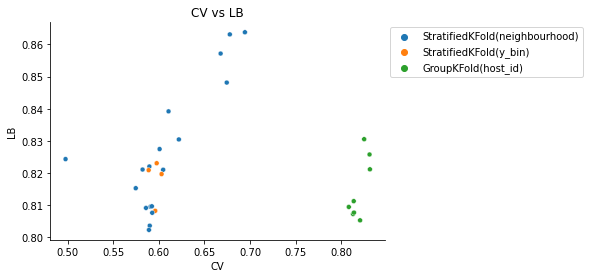

In [43]:
fig, _ = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True)
ax = sns.scatterplot(data=cv_vs_lb, x='CV', y='LB', hue='Fold', s=24)
ax.legend(loc='upper left', bbox_to_anchor=[1., 1.])
ax.set_title('CV vs LB')
sns.despine()

In [44]:
cv_vs_lb.groupby('Fold').corr()

CV        LB  Rank(CV)  \
Fold                                                                    
GroupKFold(host_id)            CV        1.000000  0.759515  0.911584   
                               LB        0.759515  1.000000  0.736048   
                               Rank(CV)  0.911584  0.736048  1.000000   
                               Rank(LB)  0.713281  0.985139  0.702186   
StratifiedKFold(neighbourhood) CV        1.000000  0.759636  0.869165   
                               LB        0.759636  1.000000  0.612188   
                               Rank(CV)  0.869165  0.612188  1.000000   
                               Rank(LB)  0.558566  0.923898  0.501499   
StratifiedKFold(y_bin)         CV        1.000000 -0.007198  0.806053   
                               LB       -0.007198  1.000000 -0.199483   
                               Rank(CV)  0.806053 -0.199483  1.000000   
                               Rank(LB)  0.027008  0.952918 -0.064121   

                                         Rank(LB)  
Fold                                               
GroupKFold(host_id)            CV        0.713281  
                               LB        0.985139  
                               Rank(CV)  0.702186  
                               Rank(LB)  1.000000  
StratifiedKFold(neighbourhood) CV        0.558566  
                               LB        0.923898  
                               Rank(CV)  0.501499  
                               Rank(LB)  1.000000  
StratifiedKFold(y_bin)         CV        0.027008  
                               LB        0.952918  
                               Rank(CV) -0.064121  
                               Rank(LB)  1.000000

## Submissions

In [45]:
submissions = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'submission*.csv')):
    sub = pd.read_csv(filepath).set_index('id').rename(columns={'y': os.path.basename(filepath).replace('.csv', '')})
    submissions.append(sub)
submissions = pd.concat(submissions, axis=1)
submissions

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,submission_011,submission_012,submission_013,submission_014,submission_015,submission_016,submission_017,submission_018,submission_019,submission_020,submission_021,submission_022,submission_023,submission_024,submission_025,submission_026,submission_027,submission_028,submission_029,submission_030,submission_031,submission_032,submission_033,submission_034,submission_035,submission_036,submission_039,submission_040,submission_041,submission_042,submission_043,submission_044,submission_045,submission_046,submission_047,submission_048,submission_049,submission_050,submission_051,submission_052,submission_053,submission_054,submission_055,submission_056,submission_057,submission_058,submission_059,submission_060,submission_063,submission_066,submission_069,submission_074
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,15563.757288,15412.997055,15149.523135,13178.117184,11980.825061,10508.393906,15667.459837,11324.098572,12065.894615,14905.229225,12359.642436,12268.293915,13470.026981,14154.321140,16046.188072,10199.773773,10798.421583,11107.227526,12057.404934,16418.334961,14659.258931,15246.903720,14419.796093,16206.881638,15386.802498,16786.292382,16597.584793,15609.081323,15823.252701,16253.897092,14621.960608,17699.943294,14873.280117,15316.742627,16246.556436,10282.161498,11905.426337,11276.138608,11836.879891,14051.953780,14883.872510,14044.043204,12570.878817,13688.446081,13952.184565,13079.820489,13328.283378,13218.448321,13543.087361,12686.444516,14248.213823,10626.164962,11227.475683,11837.535049,12571.346899,13004.704897,12923.896376,15155.872091,14029.096917,14224.240421,15093.984758,14009.654915
2,11315.311473,11800.884838,16759.002170,18896.921538,17543.344321,18547.891042,15522.055171,19381.293858,13768.671233,13016.722028,15491.592679,18860.913294,21266.603806,18915.988023,18757.732832,16369.090262,19235.375734,16490.337661,17449.632198,19956.802988,17869.436137,20573.407248,17316.461720,16836.442118,17560.705385,16586.252677,17622.791325,17792.359017,15512.766160,14130.504001,14470.844353,13653.080015,17540.660317,16322.777247,17091.614859,13441.222715,17146.895172,16463.988248,14916.523661,15907.951753,17510.003074,17172.676507,18866.241642,19355.021083,20971.350418,15720.054882,16459.544440,18640.626380,23503.924396,21260.974118,20544.143969,17376.916244,16582.370303,17164.913719,16922.369491,14396.611754,14398.015045,17741.782045,17921.895163,16242.270294,19742.051095,21214.580196
3,15921.739860,15458.861373,12868.850477,13833.183047,8661.947943,14978.764058,14609.431020,12749.191746,14776.633311,13855.485504,14029.558956,11828.666602,11617.289908,12383.932635,11853.385724,15626.689486,15218.978169,13305.617657,12110.066890,10810.736472,10402.598176,11505.213873,10738.058366,10223.928123,10838.213835,11810.854247,11495.448093,13267.600333,11738.701853,11559.778152,13597.548314,12015.640804,11579.702751,11238.952110,12015.408728,11830.817446,13320.604275,14329.091326,13087.245952,8544.952578,8600.518008,8800.261797,19658.004670,20008.923662,19092.748666,9941.199516,9580.835133,9790.696173,11120.417327,11268.193052,11753.291733,11957.304945,12427.843636,11641.176002,12981.074708,15305.147730,12515.999892,11005.494580,11494.978538,10604.534476,10999.756091,16179.940588
4,18301.790676,17935.568540,18215.072414,18200.361440,13063.205844,17165.856038,13294.381434,11831.085654,13983.897808,16297.975643,9608.618615,22485.147825,23148.060066,12954.097173,12941.253911,17508.600038,16571.300060,12051.760442,12037.040091,12868.143495,12729.281578,12774.948521,12778.420779,13987.281209,13613.303315,13793.750203,13552.933826,13538.459008,12494.680592,16455.080811,16191.077548,15519.491942,13061.715473,13864.413430,12370.166072,13036.876550,12201.468312,12593.728845,12142.766266,13578.525203,13032.176868,12511.769927,9966.755199,10167.669312,10085.250807,15

In [46]:
corr = submissions.corr()
corr

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,submission_011,submission_012,submission_013,submission_014,submission_015,submission_016,submission_017,submission_018,submission_019,submission_020,submission_021,submission_022,submission_023,submission_024,submission_025,submission_026,submission_027,submission_028,submission_029,submission_030,submission_031,submission_032,submission_033,submission_034,submission_035,submission_036,submission_039,submission_040,submission_041,submission_042,submission_043,submission_044,submission_045,submission_046,submission_047,submission_048,submission_049,submission_050,submission_051,submission_052,submission_053,submission_054,submission_055,submission_056,submission_057,submission_058,submission_059,submission_060,submission_063,submission_066,submission_069,submission_074
submission_001,1.000000,0.992997,0.636294,0.709383,0.539525,0.626795,0.742152,0.614587,0.669529,0.777660,0.677133,0.612355,0.603275,0.559345,0.579494,0.630332,0.624407,0.623208,0.621060,0.548049,0.554412,0.555348,0.603576,0.579818,0.572748,0.611517,0.565032,0.543127,0.615508,0.617851,0.587968,0.627148,0.564993,0.563917,0.597884,0.541855,0.544301,0.553530,0.572293,0.488339,0.494662,0.536008,0.598047,0.605180,0.608573,0.527505,0.529153,0.542638,0.587293,0.587358,0.593472,0.540248,0.550741,0.550544,0.585913,0.578255,0.583428,0.577649,0.533894,0.550768,0.593683,0.615896
submission_002,0.992997,1.000000,0.638716,0.713171,0.538779,0.627931,0.746296,0.615483,0.670174,0.781966,0.678528,0.614405,0.606461,0.560348,0.581401,0.630810,0.626237,0.623257,0.622510,0.548326,0.555130,0.556170,0.605280,0.580424,0.572445,0.613354,0.564557,0.543114,0.616415,0.619199,0.589031,0.629773,0.564634,0.563412,0.598556,0.544469,0.545379,0.555038,0.573979,0.489386,0.495933,0.537888,0.601310,0.609623,0.612106,0.528601,0.530489,0.545341,0.591343,0.590438,0.596706,0.542483,0.553006,0.553269,0.587025,0.581012,0.586056,0.579420,0.535853,0.552587,0.596166,0.619004
submission_003,0.636294,0.638716,1.000000,0.745140,0.703509,0.924160,0.729231,0.812588,0.885452,0.726250,0.866750,0.954826,0.934044,0.729803,0.742276,0.920851,0.901513,0.820796,0.822683,0.721538,0.715478,0.724692,0.768025,0.753615,0.739656,0.779332,0.717500,0.691204,0.767197,0.735620,0.712269,0.722636,0.715804,0.718914,0.754924,0.768894,0.762243,0.785504,0.789407,0.653157,0.648065,0.709851,0.764182,0.767534,0.743939,0.788730,0.790508,0.810495,0.939231,0.938503,0.922512,0.786644,0.808063,0.801661,0.825766,0.825965,0.808872,0.804823,0.788981,0.811478,0.825152,0.803978
submission_004,0.709383,0.713171,0.745140,1.000000,0.599688,0.734037,0.872784,0.685876,0.737677,0.882376,0.731578,0.741268,0.738621,0.623477,0.650809,0.734976,0.727150,0.692181,0.706578,0.612994,0.608443,0.618332,0.668959,0.636648,0.627072,0.673956,0.611280,0.589415,0.667102,0.638062,0.618586,0.647995,0.611150,0.609708,0.656407,0.659136,0.656403,0.670952,0.699042,0.556681,0.560083,0.621664,0.707845,0.710326,0.713535,0.630919,0.635170,0.660601,0.720694,0.722347,0.732903,0.659562,0.678025,0.695128,0.706466,0.700458,0.710919,0.659707,0.635583,0.650698,0.675544,0.733385
submission_005,0.539525,0.538779,0.703509,0.599688,1.000000,0.672951,0.584961,0.826826,0.640432,0.607285,0.672271,0.709409,0.709315,0.964817,0.955737,0.676348,0.681868,0.841018,0.801385,0.962988,0.960770,0.966684,0.951876,0.952809,0.953452,0.943075,0.954683,0.941074,0.944151,0.938224,0.942253,0.917974,0.953223,0.953991,0.942059,0.866964,0.887785,0.872253,0.852444,0.894389,0.907178,0.897442,0.572614,0.570635,0.558242,0.905245,0.911093,0.875893,0.683665,0.685038,0.695382,0.853316,0.855226,0.837375,0.830537,0.812843,0.821042,0.901720,0.898365,0.910463,0.891164,0.577477
submission_006,0.626795,0.627931,0.924160,0.734037,0.672951,1.000000,0.724703,0.820976,0.932568,0.725500,0.888004,0.942197,0.925730,0.702941,0.721062,0.991575,0.977595,0.824287,0.835714,0.692099,0.686112,

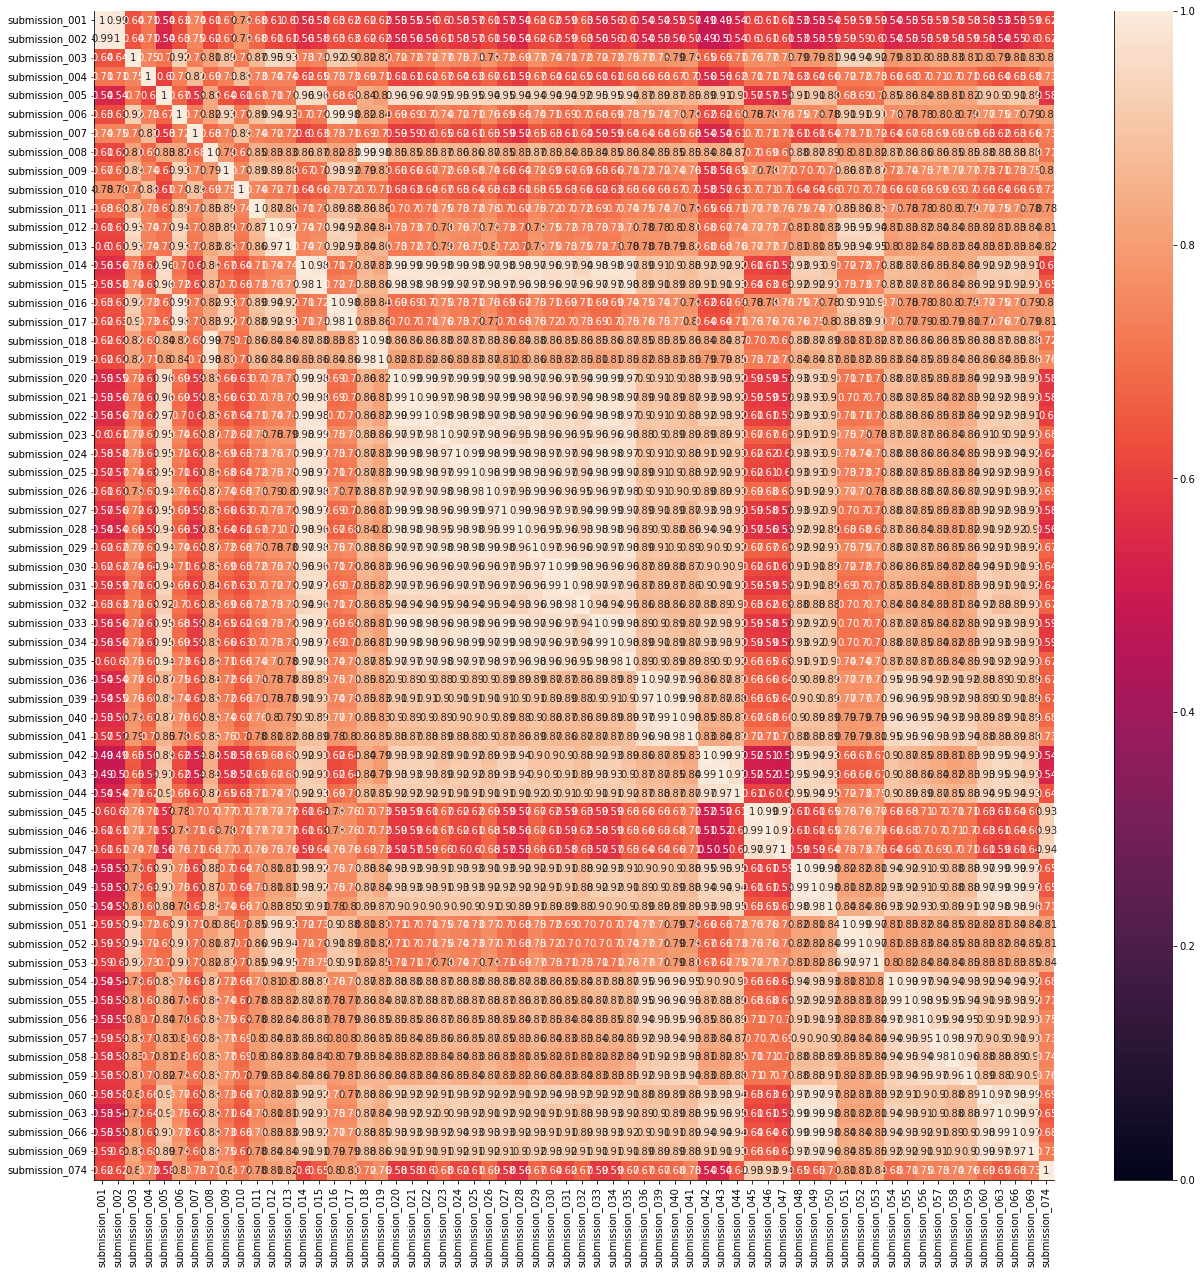

In [47]:
fig = plt.figure(figsize=(21.5, 21.5))
sns.heatmap(corr, annot=True, vmin=0., vmax=1.)
sns.despine()

In [32]:
columns = [f'submission_{no}' for no in cv_vs_lb.query('Fold == "StratifiedKFold(neighbourhood)"').index]
columns

['submission_001',
 'submission_002',
 'submission_003',
 'submission_004',
 'submission_005',
 'submission_006',
 'submission_007',
 'submission_008',
 'submission_009',
 'submission_010',
 'submission_011',
 'submission_020',
 'submission_021',
 'submission_024',
 'submission_027',
 'submission_030',
 'submission_033',
 'submission_036',
 'submission_039',
 'submission_042',
 'submission_045',
 'submission_048',
 'submission_051',
 'submission_054',
 'submission_057',
 'submission_060',
 'submission_063',
 'submission_066',
 'submission_069']

In [33]:
corr2 = submissions[columns].corr()

In [34]:
corr2

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,submission_011,submission_020,submission_021,submission_024,submission_027,submission_030,submission_033,submission_036,submission_039,submission_042,submission_045,submission_048,submission_051,submission_054,submission_057,submission_060,submission_063,submission_066,submission_069
submission_001,1.000000,0.992997,0.636294,0.709383,0.539525,0.626795,0.742152,0.614587,0.669529,0.777660,0.677133,0.548049,0.554412,0.579818,0.565032,0.617851,0.564993,0.541855,0.544301,0.488339,0.598047,0.527505,0.587293,0.540248,0.585913,0.577649,0.533894,0.550768,0.593683
submission_002,0.992997,1.000000,0.638716,0.713171,0.538779,0.627931,0.746296,0.615483,0.670174,0.781966,0.678528,0.548326,0.555130,0.580424,0.564557,0.619199,0.564634,0.544469,0.545379,0.489386,0.601310,0.528601,0.591343,0.542483,0.587025,0.579420,0.535853,0.552587,0.596166
submission_003,0.636294,0.638716,1.000000,0.745140,0.703509,0.924160,0.729231,0.812588,0.885452,0.726250,0.866750,0.721538,0.715478,0.753615,0.717500,0.735620,0.715804,0.768894,0.762243,0.653157,0.764182,0.788730,0.939231,0.786644,0.825766,0.804823,0.788981,0.811478,0.825152
submission_004,0.709383,0.713171,0.745140,1.000000,0.599688,0.734037,0.872784,0.685876,0.737677,0.882376,0.731578,0.612994,0.608443,0.636648,0.611280,0.638062,0.611150,0.659136,0.656403,0.556681,0.707845,0.630919,0.720694,0.659562,0.706466,0.659707,0.635583,0.650698,0.675544
submission_005,0.539525,0.538779,0.703509,0.599688,1.000000,0.672951,0.584961,0.826826,0.640432,0.607285,0.672271,0.962988,0.960770,0.952809,0.954683,0.938224,0.953223,0.866964,0.887785,0.894389,0.572614,0.905245,0.683665,0.853316,0.830537,0.901720,0.898365,0.910463,0.891164
submission_006,0.626795,0.627931,0.924160,0.734037,0.672951,1.000000,0.724703,0.820976,0.932568,0.725500,0.888004,0.692099,0.686112,0.723687,0.687678,0.708823,0.683982,0.750394,0.743315,0.623131,0.778794,0.753262,0.906257,0.759718,0.800600,0.767701,0.753026,0.772188,0.790457
submission_007,0.742152,0.746296,0.729231,0.872784,0.584961,0.724703,1.000000,0.681112,0.736974,0.890258,0.741812,0.594114,0.592483,0.617652,0.591945,0.629873,0.593096,0.643685,0.638092,0.542314,0.703383,0.612571,0.707107,0.642918,0.691055,0.649006,0.619647,0.634887,0.664430
submission_008,0.614587,0.615483,0.812588,0.685876,0.826826,0.820976,0.681112,1.000000,0.787521,0.692764,0.851264,0.849883,0.847927,0.860072,0.847503,0.853618,0.838516,0.843058,0.848611,0.840530,0.701069,0.878115,0.803629,0.868569,0.857512,0.879564,0.875533,0.882138,0.881550
submission_009,0.669529,0.670174,0.885452,0.737677,0.640432,0.932568,0.736974,0.787521,1.000000,0.747692,0.889757,0.660106,0.656535,0.692969,0.657491,0.688525,0.648905,0.720052,0.717006,0.584086,0.772425,0.704717,0.862450,0.722077,0.769991,0.728011,0.705950,0.727937,0.751354
submission_010,0.777660,0.781966,0.726250,0.882376,0.607285,0.725500,0.890258,0.692764,0.747692,1.000000,0.744402,0.626227,0.626529,0.648028,0.627761,0.650798,0.624273,0.658751,0.658560,0.575519,0.703689,0.635159,0.697211,0.660522,0.692502,0.659239,0.641516,0.655359,0.671308


In [36]:
corr2['submission_066'].sort_values()

submission_001    0.550768
submission_002    0.552587
submission_007    0.634887
submission_045    0.636869
submission_004    0.650698
submission_010    0.655359
submission_009    0.727937
submission_011    0.763293
submission_006    0.772188
submission_003    0.811478
submission_051    0.835735
submission_008    0.882138
submission_036    0.900170
submission_057    0.908078
submission_039    0.909048
submission_005    0.910463
submission_030    0.911934
submission_033    0.925541
submission_021    0.927626
submission_027    0.930227
submission_020    0.932506
submission_024    0.936923
submission_054    0.938633
submission_042    0.941467
submission_069    0.974310
submission_060    0.976739
submission_063    0.987374
submission_048    0.989538
submission_066    1.000000
Name: submission_066, dtype: float64